In [39]:
import pandas as pd
pd.set_option('display.max_columns', 200)
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector


In [40]:
path = Path.cwd().parent / "data/r2.csv"
df = pd.read_csv(path)

### Feature Engineering


In order to adress the outliers, quantile bucketization has been applied for chlorides, residual sugar and sulphates

In [41]:
quantiles_chlorides = list(df['chlorides'].quantile([0, 0.25, 0.5, 0.75, 1.0]))

In [42]:
labels = ['Q1', 'Q2', 'Q3', 'Q4']

df['chlorides'] = pd.cut(df['chlorides'], bins=quantiles_chlorides, labels=labels, right=True, include_lowest=True)

In [43]:
df['chlorides'].value_counts()

Q1    356
Q3    355
Q2    347
Q4    342
Name: chlorides, dtype: int64

In [44]:
quantiles_residual_sugar = list(df['residual sugar'].quantile([0, 0.25, 0.5, 0.75, 1.0]))

In [45]:
labels = ['Q1', 'Q2', 'Q3', 'Q4']

df['residual sugar'] = pd.cut(df['residual sugar'], bins=quantiles_residual_sugar, labels=labels, right=True, include_lowest=True)

In [46]:
quantiles_sulphates = list(df['sulphates'].quantile([0, 0.25, 0.5, 0.75, 1.0]))

In [47]:
labels = ['Q1', 'Q2', 'Q3', 'Q4']

df['sulphates'] = pd.cut(df['sulphates'], bins=quantiles_sulphates, labels=labels, right=True, include_lowest=True)

### Feature Preprocessing

For numeric features MinMax scaling has been applied, and categorical ones have been encoded using one hot encoder.
Preprocessor has been fitted and transformed on the train sample, only transformed on the tast sample to avoid data leakge.

In [48]:
X = df.drop(['quality', 'id'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

cols_to_scale = X_train.columns.drop(['chlorides', 'residual sugar', 'sulphates'])
cols_to_encode = ['chlorides', 'residual sugar', 'sulphates']

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), cols_to_scale),
        ('cat', OneHotEncoder(), cols_to_encode)
    ]
)

X_train = preprocessor.fit_transform(X_train)
columns = cols_to_scale.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(cols_to_encode).tolist()
X_train = pd.DataFrame(X_train, columns=columns)

X_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns)

In [49]:
X_train_sample, X_val, y_train_sample, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [50]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Initially, 8 base regressors have been applied. 

In [51]:
# Empty DataFrame to store results
results_df = pd.DataFrame(index=['Linear Regression', 'Bagging Linear Regression', 'SVR', 'Bagging SVR', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
                           columns=['Train_R2', 'Val_R2', 'Train_MAPE', 'Val_MAPE', 'Train_RMSE', 'Val_RMSE'])

base_reg_lr = LinearRegression()
base_reg_svr = SVR()

models = {
    'Linear Regression': LinearRegression(),
    'Bagging Linear Regression': BaggingRegressor(base_reg_lr, n_estimators=30, random_state=123),
    'SVR': SVR(),
    'Bagging SVR': BaggingRegressor(base_reg_svr, n_estimators=30, random_state=123),
    'Decision Tree': DecisionTreeRegressor(random_state=123, max_depth=3, min_samples_leaf=0.13),
    'Random Forest': RandomForestRegressor(random_state=123),
    'XGBoost': XGBRegressor(random_state=123),
    'LightGBM': LGBMRegressor(random_state=123)
}

for model_name, model in models.items():
    # Fit the model on the training set
    model.fit(X_train_sample, y_train_sample)
    
    # Evaluate on the training set
    train_predictions = model.predict(X_train_sample)
    train_r2 = r2_score(y_train_sample, train_predictions)
    train_rmse = np.sqrt(mean_squared_error(y_train_sample, train_predictions))
    train_mape = mean_absolute_percentage_error(y_train_sample, train_predictions)
    
    # Evaluate on the validation set
    val_predictions = model.predict(X_val)
    val_r2 = r2_score(y_val, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    val_mape = mean_absolute_percentage_error(y_val, val_predictions)
    
    results_df.loc[model_name] = [train_r2, val_r2, train_mape, val_mape, train_rmse, val_rmse]

display(results_df.sort_values(by='Val_MAPE', ascending=False))


,Train_R2,Val_R2,Train_MAPE,Val_MAPE,Train_RMSE,Val_RMSE
Decision Tree,0.166873,0.090677,17.585576,19.54868,1.119756,1.258874
SVR,0.44701,0.188573,13.274385,18.837877,0.912276,1.189181
XGBoost,0.999689,0.156318,0.284894,18.755004,0.021644,1.212586
Bagging SVR,0.44708,0.193568,13.751856,18.723399,0.912218,1.185515
LightGBM,0.972617,0.197541,3.043187,18.487144,0.203005,1.182591
Random Forest,0.892246,0.242856,6.337504,17.75722,0.402702,1.148716
Bagging Linear Regression,0.257351,0.242384,16.64001,17.588544,1.057206,1.149073
Linear Regression,0.252533,0.238291,16.569106,17.485227,1.06063,1.152173


Then, voting regressor with 5 base models, that initially gave the best results was trained.

In [52]:
results_df = pd.DataFrame(index=['Voting Regressor'],
                           columns=['Train_R2', 'Val_R2', 'Train_MAPE', 'Val_MAPE', 'Train_RMSE', 'Val_RMSE'])

base_reg_lr = LinearRegression()
base_reg_svr = SVR()

models = [
    ('Bagging Linear Regression', BaggingRegressor(base_reg_lr, n_estimators=30, random_state=123)),
    ('Bagging SVR', BaggingRegressor(base_reg_svr, n_estimators=30, random_state=123)),
    ('Decision Tree', DecisionTreeRegressor(random_state=123)),
    ('Random Forest', RandomForestRegressor(random_state=123)),
    ('XGBoost', XGBRegressor(random_state=123))
]

voting_regressor = VotingRegressor(models)

# Fit the model on the training set
voting_regressor.fit(X_train_sample, y_train_sample)

# Evaluate on the training set
train_predictions = voting_regressor.predict(X_train_sample)
train_r2 = r2_score(y_train_sample, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train_sample, train_predictions))
train_mape = mean_absolute_percentage_error(y_train_sample, train_predictions)

# Evaluate on the validation set
val_predictions = voting_regressor.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_mape = mean_absolute_percentage_error(y_val, val_predictions)

results_df.loc['Voting Regressor'] = [train_r2, val_r2, train_mape, val_mape, train_rmse, val_rmse]
display(results_df)


,Train_R2,Val_R2,Train_MAPE,Val_MAPE,Train_RMSE,Val_RMSE
Voting Regressor,0.855406,0.211744,7.285072,18.239054,0.46649,1.172079


Similarly, stacking regressor with Linear Regression meta estimator has been fitted. 

In [53]:
results_df = pd.DataFrame(index=['Stacking Regressor'],
                           columns=['Train_R2', 'Test_R2', 'Train_MAPE', 'Test_MAPE', 'Train_RMSE', 'Test_RMSE'])

base_reg_lr = LinearRegression()
base_reg_svr = SVR()

base_models = [
    ('Bagging Linear Regression', BaggingRegressor(base_reg_lr, n_estimators=30, random_state=123)),
    ('Bagging SVR', BaggingRegressor(base_reg_svr, n_estimators=30, random_state=123)),
    ('Decision Tree', DecisionTreeRegressor(random_state=123)),
    ('Random Forest', RandomForestRegressor(random_state=123)),
    ('XGBoost', XGBRegressor(random_state=123))
]

stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Fit the model on the training set
stacking_regressor.fit(X_train_sample, y_train_sample)

# Evaluate on the training set
train_predictions = stacking_regressor.predict(X_train_sample)
train_r2 = r2_score(y_train_sample, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train_sample, train_predictions))
train_mape = mean_absolute_percentage_error(y_train_sample, train_predictions)

# Evaluate on the validation set
test_predictions = stacking_regressor.predict(X_val)
test_r2 = r2_score(y_val, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_val, test_predictions))
test_mape = mean_absolute_percentage_error(y_val, test_predictions)

results_df.loc['Stacking Regressor'] = [train_r2, test_r2, train_mape, test_mape, train_rmse, test_rmse]
display(results_df)


,Train_R2,Test_R2,Train_MAPE,Test_MAPE,Train_RMSE,Test_RMSE
Stacking Regressor,0.698237,0.25451,10.580024,17.603045,0.673909,1.139841


In [54]:
X_train.shape

(1120, 30)

After checking the initial performance of different models and configurations we processed with Sequental Feature Seection with Random Forest Regressor. The algorithm selected the most relevant features.

In [55]:
# FSS_rf = SequentialFeatureSelector(
#     RandomForestRegressor(random_state=123),
#     k_features=(1,30),
#     forward=True,
#     verbose=2,
#     cv=5,
#     scoring='neg_mean_absolute_percentage_error',
#     n_jobs=-1).fit(X_train, y_train)

In [56]:
# list(FSS_rf.k_feature_names_)

In [57]:
selected_feature_names = ['alcohol',
 'citric acid',
 'feat01',
 'feat04',
 'feat07',
 'free sulfur dioxide',
 'pH',
 'total sulfur dioxide',
 'volatile acidity',
 'chlorides_Q1',
 'chlorides_Q2',
 'chlorides_Q3',
 'chlorides_Q4',
 'residual sugar_Q1',
 'residual sugar_Q2',
 'residual sugar_Q3',
 'residual sugar_Q4',
 'sulphates_Q1',
 'sulphates_Q2',
 'sulphates_Q3',
 'sulphates_Q4']

In [58]:
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

### Hyperparameter tuning

The next step was to fine tune separately each model used in both stacking and voting regressors. For this purpose, Randomized search algorithm with cross-validation on 5 folds were used.

In [59]:
# Base Linear Regression model
base_model = LinearRegression()

# Bagging Regressor with Linear Regression as base estimator
bagging_reg = BaggingRegressor(base_model, random_state=123)

# Hyperparameter grid for Bagging Regressor
params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0],
}

# RandomizedSearchCV for hyperparameter tuning
random_search_bagging = RandomizedSearchCV(
    estimator=bagging_reg,
    param_distributions=params,
    n_iter=100,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_bagging.fit(X_train, y_train)

print("Best Hyperparameters:", random_search_bagging.best_params_)

# Evaluate the model on the test set
predictions = random_search_bagging.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE:", random_search_bagging.__class__.__name__, rmse)
print("MAPE:", random_search_bagging.__class__.__name__, mape)
print("R2:", random_search_bagging.__class__.__name__, r2)


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 80 candidates, totalling 400 fits


Best Hyperparameters: {'n_estimators': 20, 'max_samples': 0.5, 'max_features': 1.0}
RMSE: RandomizedSearchCV 1.0510461246277991
MAPE: RandomizedSearchCV 15.407364490220651
R2: RandomizedSearchCV 0.16162969028701635


In [60]:
best_params_bagging_lr = {'n_estimators': 20, 'max_samples': 0.5, 'max_features': 1.0}

In [61]:
base_model = SVR()

# Hyperparameter grid for svr
params_svr = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5],
}

# Hyperparameter grid for Bagging Regressor
params_bagging_regressor = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0],
}

# RandomizedSearchCV for hyperparameter tuning for SVR
random_search_svr = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params_svr,
    n_iter=20,
    scoring='neg_mean_squared_error',  
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_svr.fit(X_train, y_train)

# Best hyperparameters for SVR
best_params_svr = random_search_svr.best_params_

# Base SVR model with optimized hyperparameters
base_model_optimized = SVR(**best_params_svr)

bagging_reg = BaggingRegressor(base_model_optimized, random_state=123)
random_search_bagging = RandomizedSearchCV(
    estimator=bagging_reg,
    param_distributions=params_bagging_regressor,
    n_iter=100,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_bagging.fit(X_train, y_train)

print("Best Hyperparameters for SVR:", best_params_svr)
print("Best Hyperparameters for Bagging Regressor:", random_search_bagging.best_params_)

# Evaluate the model on the test set
predictions = random_search_bagging.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE:", random_search_bagging.__class__.__name__, rmse)
print("MAPE:", random_search_bagging.__class__.__name__, mape)
print("R2:", random_search_bagging.__class__.__name__, r2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Hyperparameters for SVR: {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}
Best Hyperparameters for Bagging Regressor: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0}
RMSE: RandomizedSearchCV 1.050015568641571
MAPE: RandomizedSearchCV 15.385464547488878
R2: RandomizedSearchCV 0.16327293685643185


In [62]:
best_params_svr = {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}
best_params_bagging_svr = {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0}

In [63]:
decision_tree = DecisionTreeRegressor()

params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None], 
    'splitter': ['best', 'random'],
}


random_search_decision_tree = RandomizedSearchCV(
    estimator=decision_tree,
    param_distributions=params,
    n_iter=500,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_decision_tree.fit(X_train, y_train)

print("Best Hyperparameters for Decision Tree Regressor:", random_search_decision_tree.best_params_)

# Evaluate the model on the test set
predictions = random_search_decision_tree.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print("RMSE:", random_search_decision_tree.__class__.__name__, rmse)
print("MAPE:", random_search_decision_tree.__class__.__name__, mape)
print("R2:", random_search_decision_tree.__class__.__name__, r2)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 270 is smaller than n_iter=500. Running 270 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters for Decision Tree Regressor: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5}
RMSE: RandomizedSearchCV 1.1085302055581054
MAPE: RandomizedSearchCV 16.46987022805065
R2: RandomizedSearchCV 0.06741719856247586


In [64]:
best_params_decision_tree = {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}

In [65]:
base_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}


random_search_random_forest = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_random_forest.fit(X_train, y_train)

print("Best Hyperparameters for Random Forest:", random_search_random_forest.best_params_)

# Evaluate the model on the test set
predictions = random_search_random_forest.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE:", random_search_random_forest.__class__.__name__, rmse)
print("MAPE:", random_search_random_forest.__class__.__name__, mape)
print("R2:", random_search_random_forest.__class__.__name__, r2)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
RMSE: RandomizedSearchCV 1.01258485918395
MAPE: RandomizedSearchCV 15.040934854435225
R2: RandomizedSearchCV 0.22186455624615142


In [66]:
best_params_rf = {'n_estimators': 200, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

In [67]:
base_model = XGBRegressor()

params_xgboost = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 15],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'min_child_weight': [0, 1, 2, 3, 4, 5],
}

random_search_xgboost = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params_xgboost,
    n_iter=100,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=3,
    random_state=123
)

random_search_xgboost.fit(X_train, y_train)

print("Best Hyperparameters for XGBoost:", random_search_xgboost.best_params_)

# Evaluate the model on the test set
predictions = random_search_xgboost.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE:", random_search_xgboost.__class__.__name__, rmse)
print("MAPE:", random_search_xgboost.__class__.__name__, mape)
print("R2:", random_search_xgboost.__class__.__name__, r2)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters for XGBoost: {'subsample': 0.5, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
RMSE: RandomizedSearchCV 1.024684619324475
MAPE: RandomizedSearchCV 15.295918861707545
R2: RandomizedSearchCV 0.20315697762011253


In [68]:
best_params_xgb = {'subsample': 0.5, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

Having the hyperparameter for each model tuned, time to check if we managed to improve results of base models. Let's do it in a proper way, defining a pipeline for for transformation and modelling and validate the results using 5 fold crossvalidation.

Stacking Regressor

In [72]:
X = df.drop(['quality', 'id', 'density', 'feat02', 'feat03', 'feat05', 'feat06', 'feat08', 'feat09', 'feat10', 'fixed acidity'], axis=1)
y = df['quality']

cols_to_scale = X.columns.drop(['chlorides', 'residual sugar', 'sulphates'])

cols_to_encode = ['chlorides', 'residual sugar', 'sulphates']

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_scale),
        ('cat', categoric_transformer, cols_to_encode)
    ]
)

base_reg_lr = LinearRegression()
base_reg_svr = SVR(**best_params_svr)

base_models = [
    ('Bagging Linear Regression', BaggingRegressor(base_reg_lr, **best_params_bagging_lr, random_state=123)),
    ('Bagging SVR', BaggingRegressor(base_reg_svr, **best_params_bagging_svr, random_state=123)),
    ('Decision Tree', DecisionTreeRegressor(**best_params_decision_tree, random_state=123)),
    ('Random Forest', RandomForestRegressor(**best_params_rf, random_state=123)),
    ('XGBoost', XGBRegressor(**best_params_xgb, random_state=123))
]

stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=base_reg_lr)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', stacking_regressor)
    ] 
)

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_percentage_error(y, y_pred)

cv_rmse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_mape = cross_val_score(pipeline, X, y, cv=5, scoring=mape_scorer)
cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

resutls_df2 = pd.DataFrame(index=['Stacking Regressor'],
                            columns=['RMSE', 'MAPE', 'R2'])

resutls_df2.loc['Stacking Regressor'] = [-cv_rmse.mean(), cv_mape.mean(), cv_r2.mean()]
display(resutls_df2)

c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocess

,RMSE,MAPE,R2
Stacking Regressor,1.062143,16.528961,0.248389


Voting Regressor

In [73]:
X = df.drop(['quality', 'id', 'density', 'feat02', 'feat03', 'feat05', 'feat06', 'feat08', 'feat09', 'feat10', 'fixed acidity'], axis=1)
y = df['quality']

cols_to_scale = X.columns.drop(['chlorides', 'residual sugar', 'sulphates'])

cols_to_encode = ['chlorides', 'residual sugar', 'sulphates']

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_scale),
        ('cat', categoric_transformer, cols_to_encode)
    ]
)

base_reg_lr = LinearRegression()
base_reg_svr = SVR(**best_params_svr)

models = [
    ('Bagging Linear Regression', BaggingRegressor(base_reg_lr, **best_params_bagging_lr, random_state=123)),
    ('Bagging SVR', BaggingRegressor(base_reg_svr, **best_params_bagging_svr, random_state=123)),
    ('Decision Tree', DecisionTreeRegressor(**best_params_decision_tree, random_state=123)),
    ('Random Forest', RandomForestRegressor(**best_params_rf, random_state=123)),
    ('XGBoost', XGBRegressor(**best_params_xgb, random_state=123))
]

voting_regressor = VotingRegressor(models)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', voting_regressor)
    ]
)

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_percentage_error(y, y_pred)

# Perform cross-validation
cv_rmse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_mape = cross_val_score(pipeline, X, y, cv=5, scoring=mape_scorer)
cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

resutls_df2.loc['Voting Regressor'] = [-cv_rmse.mean(), cv_mape.mean(), cv_r2.mean()]
display(resutls_df2)


c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocess

,RMSE,MAPE,R2
Stacking Regressor,1.062143,16.528961,0.248389
Voting Regressor,1.08101,16.854866,0.221863


And additionally, Random Forest Regressor

In [74]:
X = df.drop(['quality', 'id', 'density', 'feat02', 'feat03', 'feat05', 'feat06', 'feat08', 'feat09', 'feat10', 'fixed acidity'], axis=1)
y = df['quality']

cols_to_scale = X.columns.drop(['chlorides', 'residual sugar', 'sulphates'])

cols_to_encode = ['chlorides', 'residual sugar', 'sulphates']

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_scale),
        ('cat', categoric_transformer, cols_to_encode)
    ]
)

rf = RandomForestRegressor(**best_params_rf, random_state=123)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf)
    ]
)

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_percentage_error(y, y_pred)

# Perform cross-validation
cv_rmse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_mape = cross_val_score(pipeline, X, y, cv=5, scoring=mape_scorer)
cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

resutls_df2.loc['Random Forest'] = [-cv_rmse.mean(), cv_mape.mean(), cv_r2.mean()]
display(resutls_df2)





c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocess

,RMSE,MAPE,R2
Stacking Regressor,1.062143,16.528961,0.248389
Voting Regressor,1.08101,16.854866,0.221863
Random Forest,1.062052,16.545573,0.248867


And the very end, we can check the feature importance in our model. It seems like features 04 and 01, added by the Proffessor, player ver significant role in our model.

c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


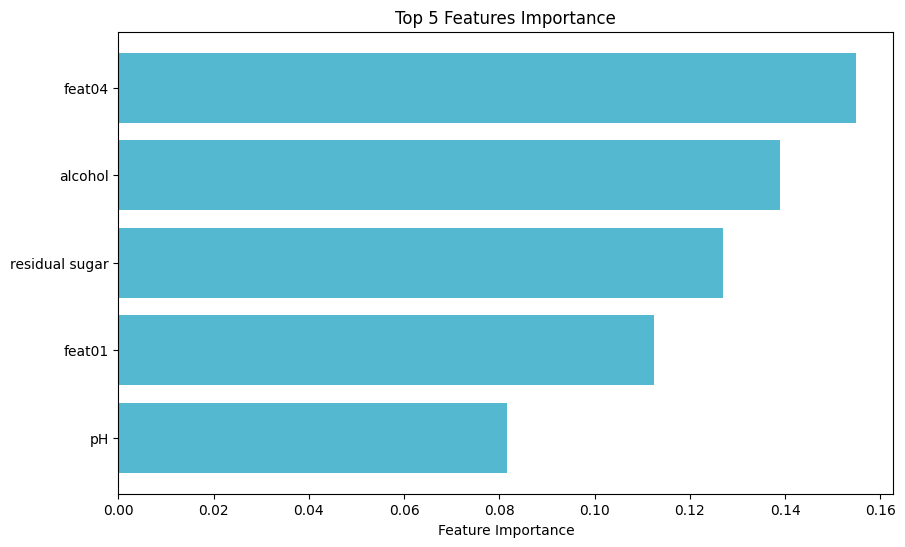

In [85]:
pipeline.fit(X, y)

sorted_idx = rf.feature_importances_.argsort()

# Select the last five elements
top_features_idx = sorted_idx[-5:]

# Plotting only the top five features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[top_features_idx], rf.feature_importances_[top_features_idx], color = '#54b8d1')
plt.xlabel('Feature Importance')
plt.title('Top 5 Features Importance')
plt.show()

For practice we wanted to check the performance of neural networks in our data. We wanted to chekc some of the configurations and it's performance. We tested many architectures of the network of neurons, and the configuration below gave the best results. Then we wanted to check which activation fuction would be the most powerful. To do that we created a loop that train and validate the model outcome for different confgurations f learning rate and activation functions. It turned out that learing rate = 0.01 adn activation fuction 'relu' gave the best results. 

In [76]:
X = df.drop(['quality', 'id', 'density', 'feat02', 'feat03', 'feat05', 'feat06', 'feat08', 'feat09', 'feat10', 'fixed acidity'], axis=1)
y = df['quality']

cols_to_scale = X.columns.drop(['chlorides', 'residual sugar', 'sulphates'])

cols_to_encode = ['chlorides', 'residual sugar', 'sulphates']

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_scale),
        ('cat', categoric_transformer, cols_to_encode)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train = preprocessor.fit_transform(X_train)
columns = cols_to_scale.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(cols_to_encode).tolist()
X_train_scaled = pd.DataFrame(X_train, columns=columns)

X_test = preprocessor.transform(X_test)
X_test_scaled = pd.DataFrame(X_test, columns=columns)

learning_rates = [0.001, 0.01, 0.1]
activation_functions = ['relu', 'tanh', 'sigmoid']

results = []

for lr in learning_rates:
    for activation_func in activation_functions:
        model = Sequential()
        model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation=activation_func))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation=activation_func))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation=activation_func))
        model.add(Dropout(0.4))
        model.add(Dense(64, activation=activation_func))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation=activation_func))
        model.add(Dropout(0.5))
        model.add(Dense(16, activation=activation_func))
        model.add(Dropout(0.5))
        model.add(Dense(1))

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=300, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluate the model on the test set
        predictions = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        mape = mean_absolute_error(y_test, predictions) / abs(y_test).mean() * 100
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)

        results.append({
            'lr': lr,
            'activation_func': activation_func,
            'mse': mse,
            'mae': mae,
            'mape': mape,
            'rmse': rmse,
            'r2': r2
        })

results_df = pd.DataFrame(results)
results_df.sort_values('mape', ascending=True)

c:\Users\filsz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(





9/9 [==============================] - 0s 2ms/step


,lr,activation_func,mse,mae,mape,rmse,r2
3,0.010,relu,1.211825,0.868018,15.087844,1.100829,0.080330
4,0.010,tanh,1.317773,0.914930,15.903255,1.147943,-0.000076
7,0.100,tanh,1.319503,0.916068,15.923037,1.148696,-0.001389
5,0.010,sigmoid,1.323625,0.918186,15.959859,1.150489,-0.004517
6,0.100,relu,1.362759,0.933385,16.224039,1.167373,-0.034216
8,0.100,sigmoid,1.377482,0.938429,16.311721,1.173662,-0.045390
1,0.001,tanh,1.409723,0.949526,16.504602,1.187318,-0.069858
2,0.001,sigmoid,1.432669,0.957252,16.638893,1.196941,-0.087272
0,0.001,relu,1.543144,0.988366,17.179721,1.242234,-0.171113


## Summary

The project aimed to apply a comprehensive set of machine learning techniques learned in class, including boosting, bagging, stacking, and neural networks. It involved a systematic approach to machine learning, covering essential steps such as initial data preprocessing, data cleaning, exploratory data analysis, feature engineering, and preprocessing. To ensure robustness, the project employed advanced methodologies like avoiding data leakage through the use of pipelines.

The modeling phase included the implementation of various ensemble methods like boosting, bagging, and stacking, along with the integration of neural networks to explore their capabilities. The project followed best practices in machine learning, incorporating hyperparameter tuning through randomized search to optimize model performance.

Results of the modeeling were discussed during the presentation in class.